# MLCMS Exercise 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
from sklearn.decomposition import PCA

import utils
import plotter
from solver import SolverLinear, SolverRadialBasis

from datafold.utils.plot import plot_pairwise_eigenvector
from utils import *
from plotter import *


DATA_PATH = os.getcwd() + "/data/"
FIGURE_PATH = os.getcwd() + "/figures/"

plt.rcParams['figure.dpi'] = 200
# plt.rcParams["figure.autolayout"] = True

%load_ext autoreload
%autoreload 2

## Task 1
### Reading in Data

In [2]:
A = np.loadtxt(DATA_PATH + "linear_function_data.txt")
B = np.loadtxt(DATA_PATH + "nonlinear_function_data.txt")
X_a = A[:, 0]
F_a = A[:, 1]
X_b = B[:, 0]
F_b = B[:, 1]

Explore data

### Approximating Dataset (A) by a Linear Function
From the sheet we can use that
$$
\begin{aligned}
    (X^T X) \hat{A}^T = X^T F
\end{aligned}
$$
In our case $X^T X$ and $X^T F$ are scalars, hence $\hat{A}^T =: a$ is too.

In [3]:
slope_a = utils.linear_basis_lst_sqr_approx(X_a, F_a)
print("Slope = ", slope_a)

Slope =  0.7500002401387145


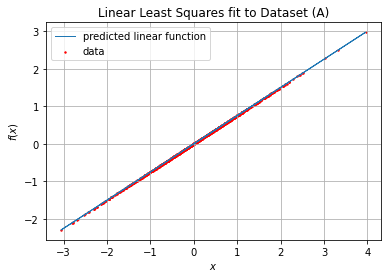

In [4]:
plt.title("Linear Least Squares fit to Dataset (A)")
plt.plot(X_a, slope_a * X_a, linewidth=1, label="predicted linear function")
plotter.basic_data_plot_task1(X_a, F_a)
plt.savefig(FIGURE_PATH + "T1_linear_linear.png", bbox_inches='tight')

### Approximating Dataset (B) by a Linear Function

In [5]:
slope_b = utils.linear_basis_lst_sqr_approx(X_b, F_b)
print("Slope = ", slope_b)

Slope =  0.03321036077811993


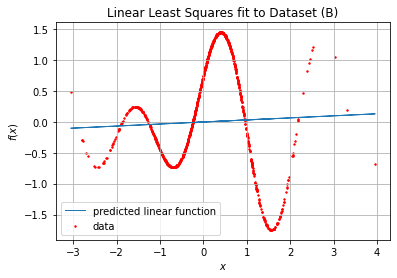

In [6]:
plt.title("Linear Least Squares fit to Dataset (B)")
plt.plot(X_b, slope_b * X_b, linewidth=1, label="predicted linear function")
plotter.basic_data_plot_task1(X_b, F_b)
plt.savefig(FIGURE_PATH + "T1_non-linear_linear.png", bbox_inches='tight')

### Approximating Dataset (B) by a Combination of Radial Functions

To aid our intuition and improve our estimation of the required $L$ and $\epsilon$ we observe that the characteristic features of the data have a characteristic length scale of approximately one, since the maxima and minima have a separation of 1 unit of length. We plot two opposite unit Gaussians next to each other:

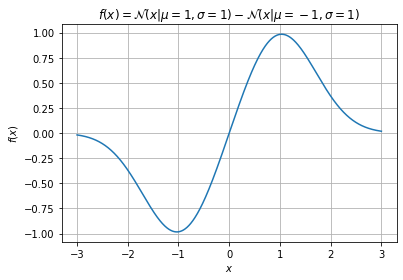

In [7]:
x_gaussian_plot = np.linspace(-3, 3, 1000)
G = np.exp(-(x_gaussian_plot-1)**2) - np.exp(-(x_gaussian_plot+1)**2)
plt.plot(x_gaussian_plot, G)
plt.grid(True)
plt.title(r"$f(x) = \mathcal{N}(x| \mu = 1, \sigma = 1) - \mathcal{N}(x| \mu = -1, \sigma = 1)$")
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.savefig(FIGURE_PATH + "T1_two_gaussians.png", bbox_inches='tight')

For peaks at a distance of one we require the grid spacing of gaussian peaks to be at least on a length scale of $1$. Additionally we note that if the data peaks do not coincide with the grid, we require a higher grid density, hence we double the number of peaks from $8$ at approximately $-3, -2, -1, 0, 1, 2, 3, 4$ to $16$.
Hence we estimate that a good approximation can be achieved by a grid with $L = 16$ at a separation of about $1/2$ with an $\epsilon = 0.5$ as this allows the peaks to be well localized while preserving a reasonable smoothness (no excessive overlap with next nearest neighbor peaks)

In [8]:
EPSILON = 0.5
L = 16
GRID_b = np.linspace(X_b.min(), X_b.max(), L)
R_COND = 1e-2

In [9]:
coefficients = utils.radial_basis_lst_sqr_approx(X_b, F_b, GRID_b, EPSILON, R_COND)
coefficients

array([-0.20979409, -0.41947349, -0.26182823,  0.25024088,  0.13726521,
       -0.7940476 , -0.13490987,  1.01565349,  0.88086545, -0.52542151,
       -1.64241175,  0.0748271 ,  0.78691149,  0.29704133,  0.0853937 ,
        0.01962219])

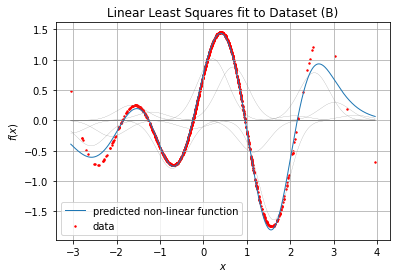

In [10]:
X_plot = np.linspace(X_b.min(), X_b.max(), 1000)
phi_plot = utils.radial_basis(X_plot, GRID_b, epsilon=EPSILON)

# plot contribution from individual basis vectors
for i, c in enumerate(coefficients):
    c_i = np.zeros(L)
    c_i[i] = c
    plt.plot(X_plot, phi_plot @ c_i.T, linewidth=0.2, color="grey")

plt.title("Linear Least Squares fit to Dataset (B)")
plt.plot(X_plot, phi_plot @ coefficients.T, linewidth=1, label="predicted non-linear function")
plotter.basic_data_plot_task1(X_b, F_b)
plt.savefig(FIGURE_PATH + "T1_non-linear_radial.png", bbox_inches='tight')

In [11]:
N = 1000
print("Total MSE", utils.compute_mse(F_b, utils.radial_basis(X_b, GRID_b, EPSILON) @ coefficients.T))

Total MSE 0.0029917257203643352


## Task 2: Approximating linear vector fields
<mark>General warning: When executing individual cells out of order, be careful that the notebook variables
like X_0, X_1, vector_field ... correspond to the correct exercise<mark>

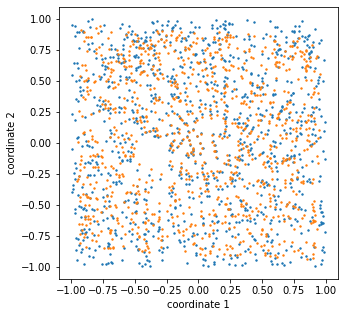

In [12]:
X_0 = np.loadtxt(DATA_PATH + "linear_vectorfield_data_x0.txt")
X_1 = np.loadtxt(DATA_PATH + "linear_vectorfield_data_x1.txt")
plotter.t3_plot_points(X_0, X_1)

### 2.1

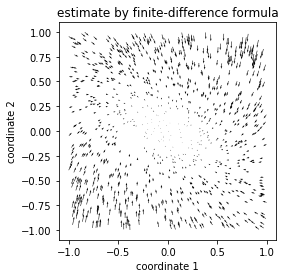

In [13]:
vector_field = utils.vector_field(X_0, X_1, dt=0.1)

ax = plt.gca()
title = "estimate by finite-difference formula"
plotter.t3_plot_vector_fields(vector_field, X_0, ax, title)
plt.show()

In [14]:
A_T, res, _, _ = scipy.linalg.lstsq(X_0, vector_field)
A = A_T.T
print(A)

[[-0.49355245  0.23191153]
 [-0.4638232  -0.95737573]]


### 2.2

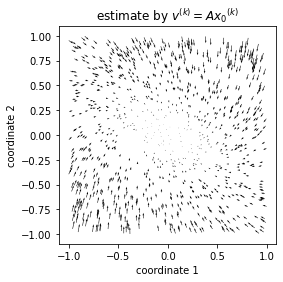

In [15]:
x1_pre = utils.t2_solve(X_0, 0, 0.1, A)
v_pre = (x1_pre - X_0) / 0.1

ax = plt.gca()
title = "estimate by $v^{(k)} = A{x_0}^{(k)}$"
plotter.t3_plot_vector_fields(v_pre, X_0, ax, title)
plt.show()

In [16]:
squared_error = np.linalg.norm(x1_pre - X_1) **2 / len(X_0)
print(f"mse = {squared_error}")

mse = 9.957557291216065e-06


### 2.3

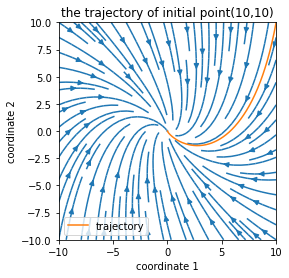

In [17]:
start_time = 0
end_time = 100
x0_point = [10, 10]

x1_pre = utils.t2_trajectory(x0_point, start_time, end_time, A)

ax = plotter.plot_phase_portrait_linear(10, A, x1_pre)
# ax.plot(x1_pre[0,:], x1_pre[1,:], label="trajectory")
# ax.legend()
# ax.set_xlim(-10,10)
# ax.set_ylim(-10,10)
# ax.set_title(ax, 15, "the trajectory of initial point(10,10)")

## Task 3

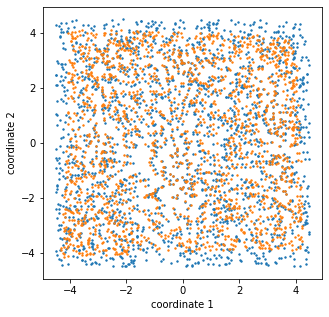

In [18]:
# Careful you need to run this cell to overwrite the data array from Task 3
X_0 = np.loadtxt(DATA_PATH + "nonlinear_vectorfield_data_x0.txt")
X_1 = np.loadtxt(DATA_PATH + "nonlinear_vectorfield_data_x1.txt")
plotter.t3_plot_points(X_0, X_1)

### 3.1 Approximate the vector field using Linear Operator
Compute vector field using finite difference. Compute the matrix $A$ using least square formula $min ||F - X A^T||^2$.

In [19]:
t_0 = 0.0
t_end = 0.1
dt = t_end - t_0

vector_field = utils.vector_field(X_0, X_1, dt)
matrix_a = utils.compute_matrix_a(X_0, vector_field)
print(f' matrix A: \n {matrix_a}')
print(X_0.shape)

 matrix A: 
 [[-0.10016012 -0.00253494]
 [ 0.00867272 -0.43267138]]
(2000, 2)


Solve the system of equations $\dot x = A x$ and compute error using norm 2.

Mean squared error: 0.03727581844374487


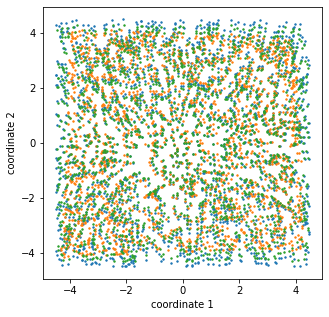

In [20]:
solver = SolverLinear(X_0, t_0, t_end, matrix_a)
x1_linear = solver.solve_linear_system()
error_linear = utils.compute_mse(X_1, x1_linear)
print(f'Mean squared error: {error_linear}')
plotter.t3_plot_points(X_0, X_1, x1_linear, fname=FIGURE_PATH + "T2_linear_prediction.png")

Plot the vector fields

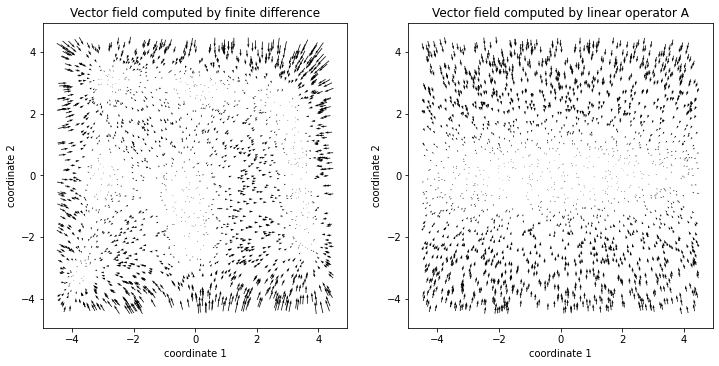

In [21]:
vector_field_computed = (x1_linear - X_0)/dt
title1 = 'Vector field computed by finite difference'
title2 = 'Vector field computed by linear operator A'
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plotter.t3_plot_vector_fields(vector_field, X_0, axes[0], title1)
plotter.t3_plot_vector_fields(vector_field_computed, X_0, axes[1], title2)
plt.show()

### 3.2 Approximate the Vector Field using Radial Basis Functions
Set the values of $\epsilon$, the number of center points $L$ as a grid, and the $cond$ value.

In [22]:
L = 100
sqrt_L = int(np.sqrt(L))
min = X_0.min()
max = X_0.max()

linear_grid = np.linspace(min, max, sqrt_L)
X, Y    = np.meshgrid(linear_grid, linear_grid)
GRID_b  = np.column_stack([X.flatten(), Y.flatten()])


EPSILON = 6.2
R_COND = 1e-8

Compute coefficients $C$ in the minimization problem: $min ||F - \Phi (X) C^T||^2$.

In [23]:
coefficients = utils.radial_basis_lst_sqr_approx(X_0, vector_field, GRID_b, EPSILON, R_COND)

Solve the system of equations $\dot x = C \phi$ and compute error using norm 2.

Linear error: 0.0008760871399744866


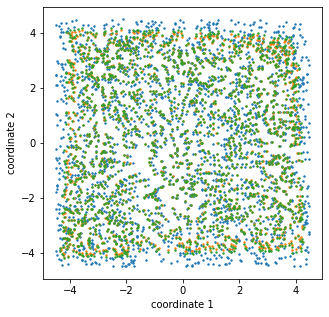

In [24]:
solver = SolverRadialBasis(X_0, t_0, t_end, coefficients, GRID_b, EPSILON)
x1_nonlinear = solver.solve_linear_system()
error_nonlinear = utils.compute_mse(X_1, x1_nonlinear)
print(f'Linear error: {error_nonlinear}')
plotter.t3_plot_points(X_0, X_1, x1_nonlinear)

Plot the vector fields

<AxesSubplot: title={'center': 'Vector field computed by radial basis function'}, xlabel='coordinate 1', ylabel='coordinate 2'>

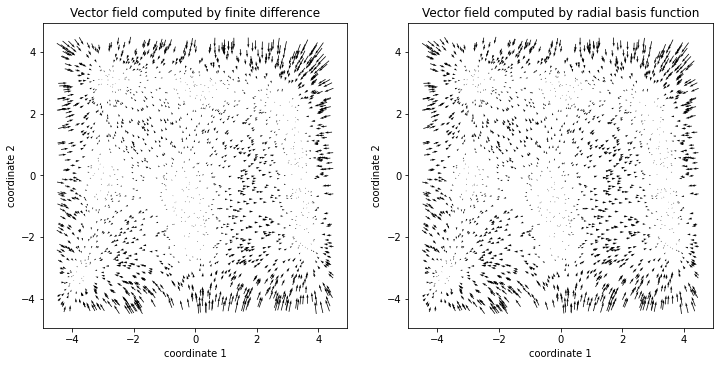

In [25]:
vector_field_computed = (x1_nonlinear - X_0)/dt
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
title3 = 'Vector field computed by radial basis function'
plotter.t3_plot_vector_fields(vector_field, X_0, axes[0], title1)
plotter.t3_plot_vector_fields(vector_field_computed, X_0, axes[1], title3)

### 3.3 Solve for longer time
solve the ODE for a longer period of time.

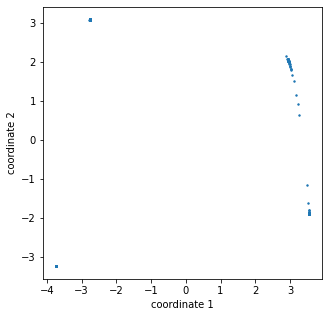

In [26]:
t_end = 10

solver = SolverRadialBasis(X_0, t_0, t_end, coefficients, GRID_b, EPSILON)
x1_nonlinear = solver.solve_linear_system()
error_nonlinear = utils.compute_mse(X_1, x1_nonlinear)
plotter.t3_plot_points(x1_nonlinear)

## Task 4

In [27]:
T4_DATA = np.loadtxt(DATA_PATH + "takens_1.txt")

In [28]:
X = T4_DATA[:, 0]

Text(0.5, 1.0, 'Periodic $X$ Data of the Manifold')

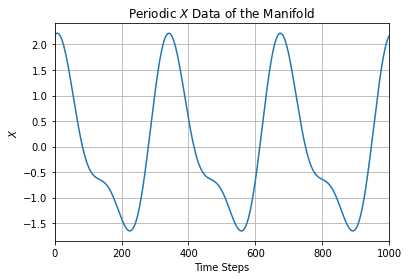

In [29]:
plt.plot(X)
plt.xlabel("Time Steps")
plt.ylabel(r"$X$")
plt.grid(True)
plt.xlim(0,1000)
plt.title(r"Periodic $X$ Data of the Manifold")

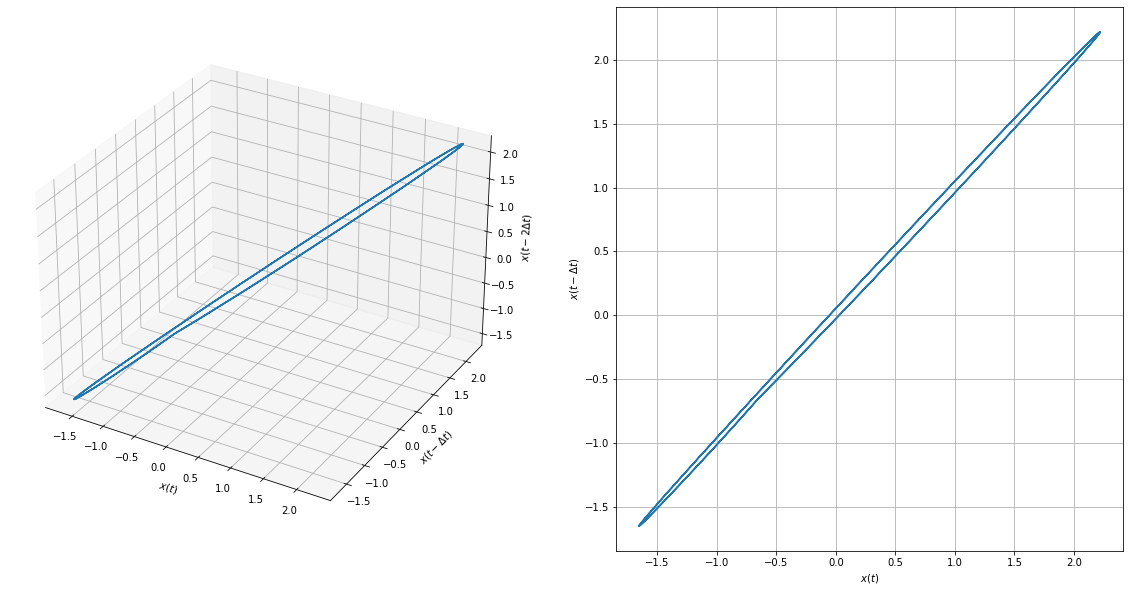

In [30]:
plotter.t4_takens(X, 1, is_periodic=True)

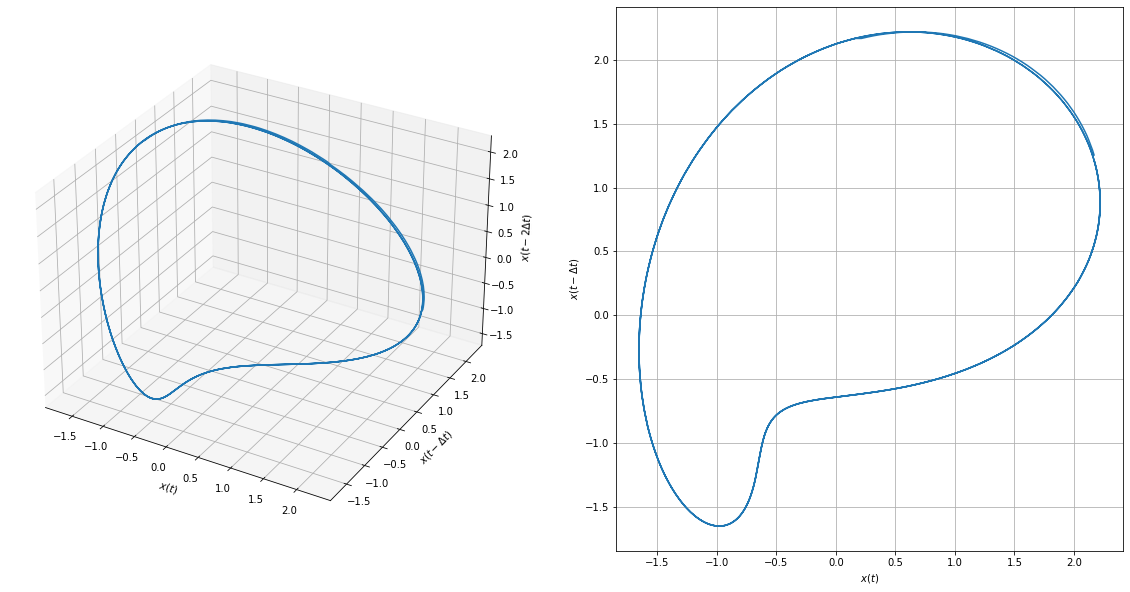

In [31]:
plotter.t4_takens(X, 50, is_periodic=True)

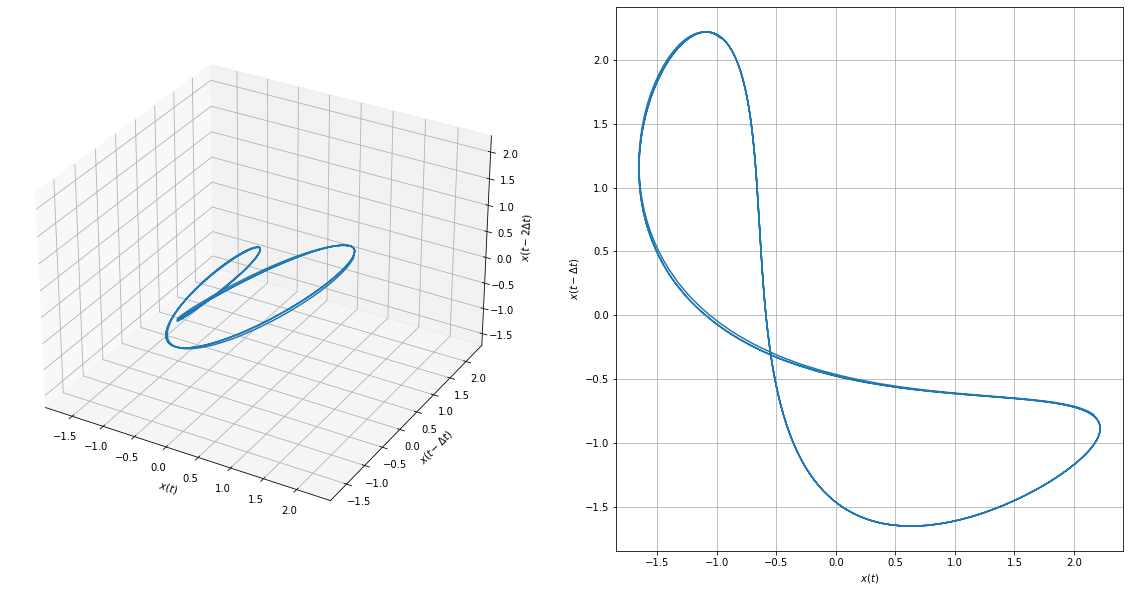

In [32]:
plotter.t4_takens(X, 160, is_periodic=True)

### 4.2

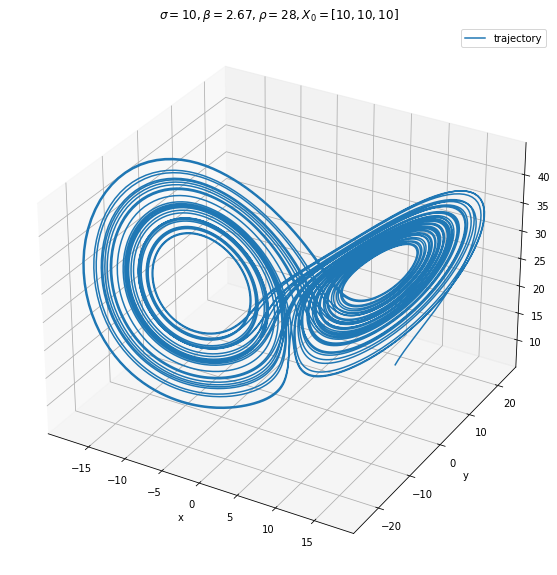

In [33]:
# Parameters:
RHO = 28
SIGMA = 10
BETA = 8/3
X0 = np.array([10, 10, 10])

start_time = 0
end_time = 50
X = utils.lorenz_trajectory(X0, SIGMA, BETA, RHO, start_time, end_time)
X = X.T

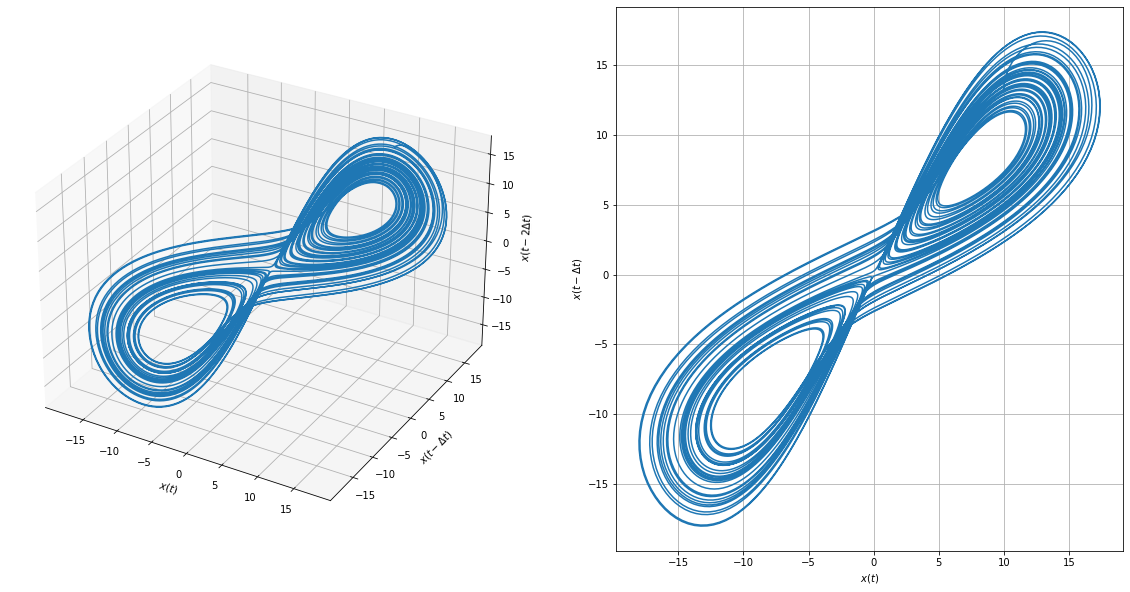

In [34]:
plotter.t4_takens(X[:, 0], delta_t=15)

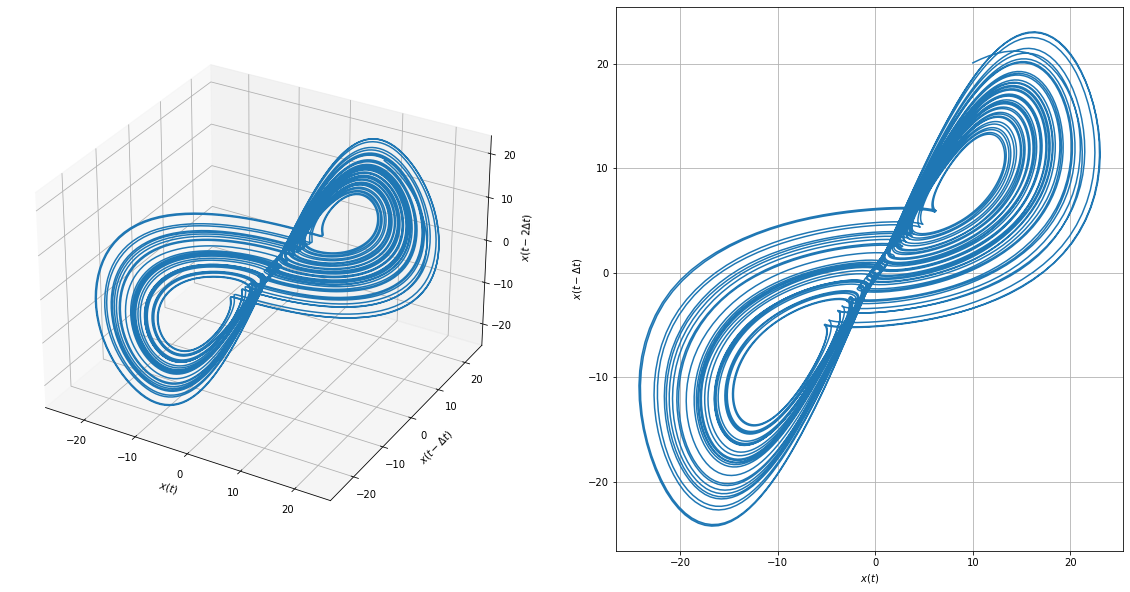

In [35]:
plotter.t4_takens(X[:, 1], delta_t=15)

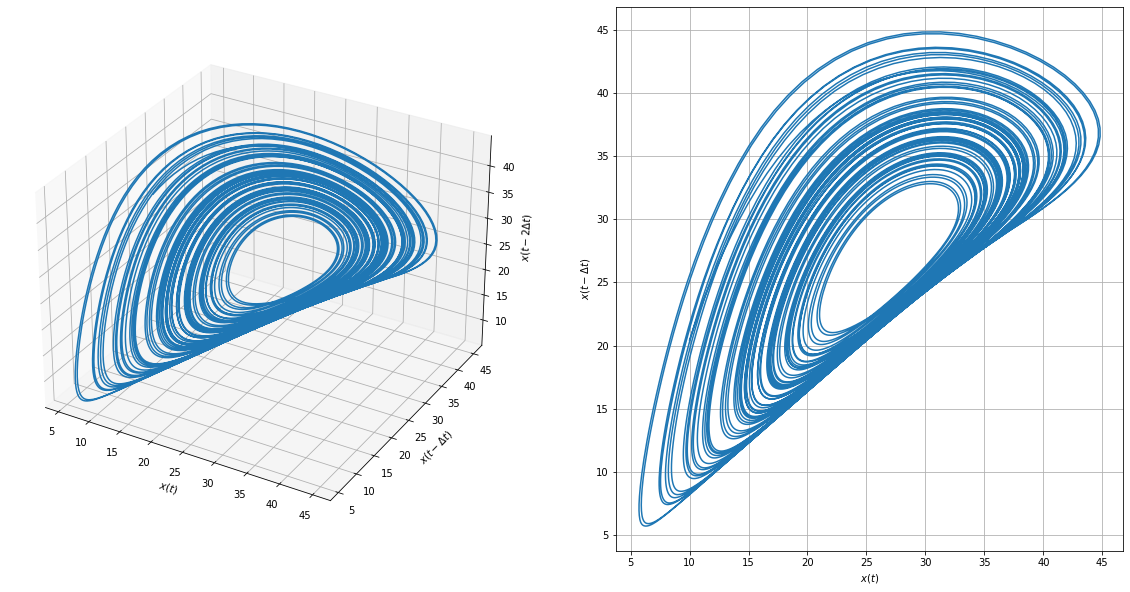

In [36]:
plotter.t4_takens(X[:, 2], delta_t=15)

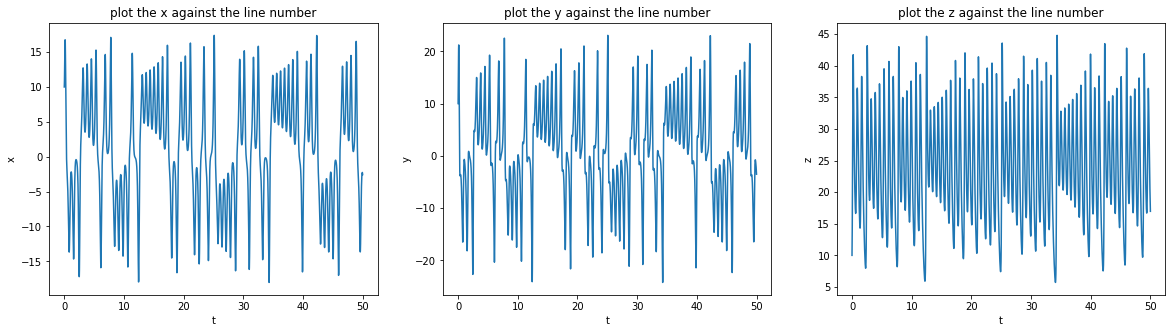

In [37]:
fig = plt.figure(figsize=(20,5))
ax0 = fig.add_subplot(1, 3, 1)
ax1 = fig.add_subplot(1, 3, 2)
ax2 = fig.add_subplot(1, 3, 3)

time_values = np.linspace(start_time, end_time, 10000)

plotter.t4_coordinate_vs_index(X[:,0], time_values, "x", ax0)
plotter.t4_coordinate_vs_index(X[:,1], time_values, "y", ax1)
plotter.t4_coordinate_vs_index(X[:,2], time_values, "z", ax2)

### 4.bonus

In [38]:
x = utils.time_delay(X[:,0], 15).T
x_0 = x[:-1]
x_1 = x[1:]
v = (x_1 - x_0) / 0.01

In [39]:
EPSILON = 6.2
L = 20j
GRID_b = np.mgrid[x_0.min():x_0.max():L, x_0.min():x_0.max():L, x_0.min():x_0.max():L]
GRID_b = GRID_b.reshape(3, GRID_b[0].size).T
GRID_b[:, [2, 1, 0]] = GRID_b[:, [0, 1, 2]]
R_COND = 1e-5

In [40]:
coefficients = utils.radial_basis_lst_sqr_approx(x_0, v, GRID_b, EPSILON, R_COND)

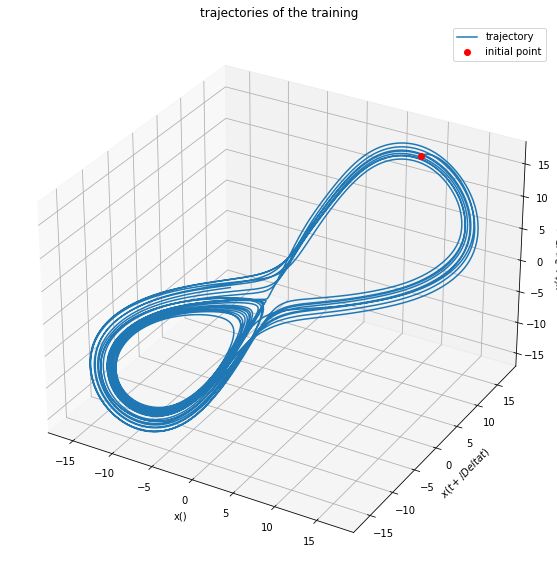

In [41]:
end_time = 50
sovler = utils.t4_fun_radial_trajectory(x_0[0,:], GRID_b, EPSILON, coefficients, start_time, end_time)

## Task 5
### Part 1: Create a reasonable state

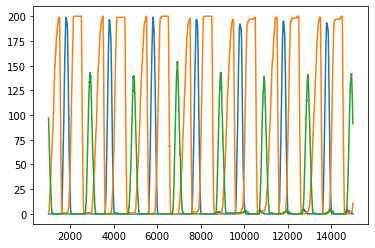

In [3]:
# U: utilizations
U = np.loadtxt(DATA_PATH + "MI_timesteps.txt")
U = U[1000:,]

# consider first three measurments
plt.plot(U[:,0], U[:,1:4])

Create a reasonable state space of the given system using PCA

In [4]:
number_of_delays = 351  # time delay embedding with 350 delays
u_one_to_three = U[:,1:4]  # consider first three columns

window = []
for row in range(u_one_to_three.shape[0]-number_of_delays):
    window.append(u_one_to_three[row:row+number_of_delays].flatten())
window = np.array(window)
print(f'The window shape is {window.shape}')

The window shape is (13650, 1053)


## Part 2: Plot the embedded points
Plot the embedded points in PCA space for the 9 measurements based on different colors

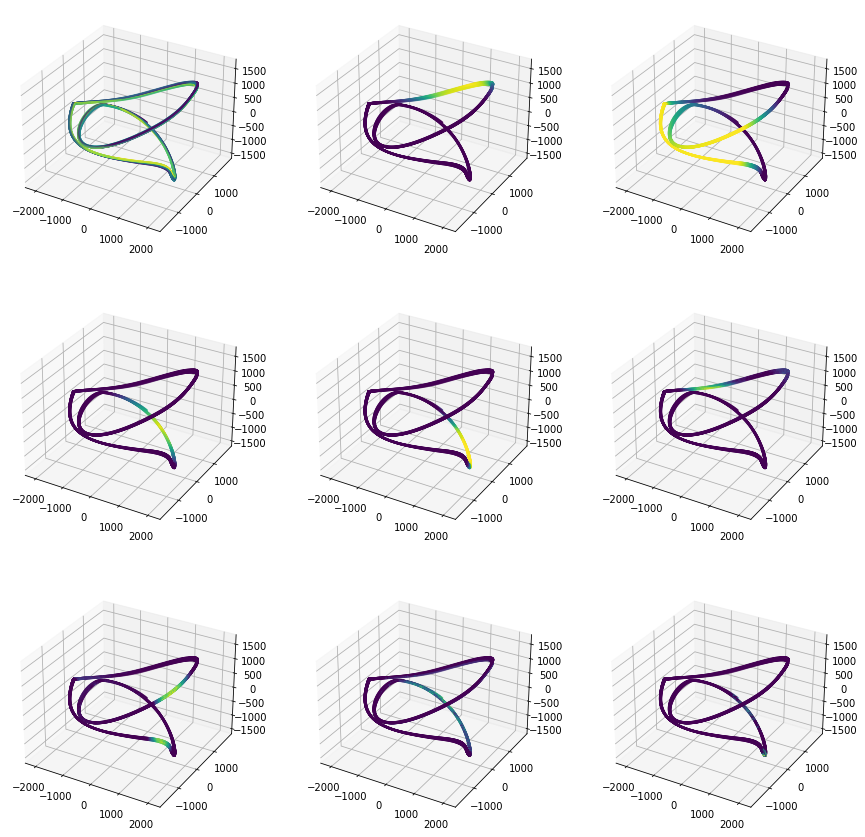

In [5]:
pca = PCA(n_components=3)
u_pca = pca.fit_transform(window)
plot_pca(u_pca, U, window.shape, 3, 3)

## Part 3: Learning the embedded data
We first need to find out how many times the periodic data is repeated. To do so, we can compute diffusion maps of the PCA data set by computing of the arctan of the embedded pair of eigenfunctions (here $\arctan( \psi_1 / \psi_2$).

In [6]:
sample = 4
evecs, evals = compute_eigenfunctions_datafold(u_pca, sample)

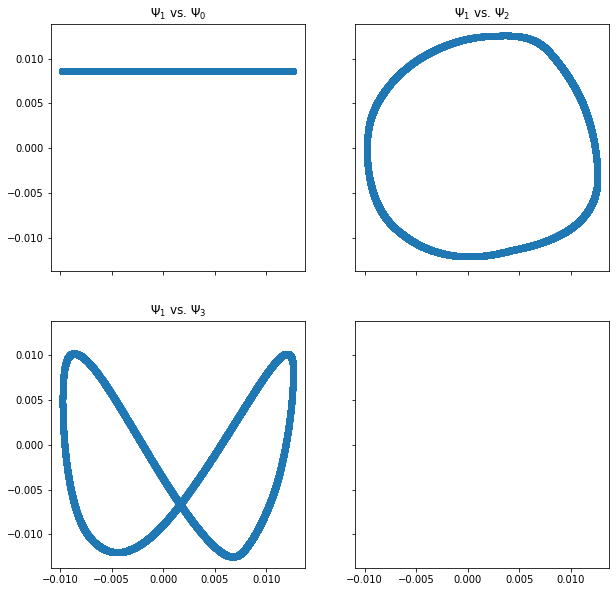

In [7]:
# Plot the eigenfunction phi_1 with respect to the others
plot_pairwise_eigenvector( eigenvectors=evecs, n=1, fig_params=dict(figsize=[10, 10]))

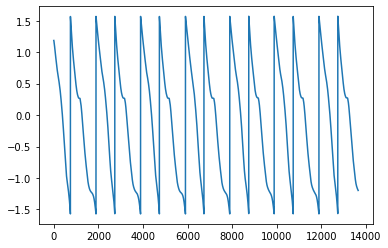

In [8]:
evecs_atan = np.arctan(evecs[:,1]/evecs[:,2])
plt.plot(evecs_atan)

It seems that there is a period at almost every almost every 2000 time steps.

In [9]:
# This part is to find out the elements that are close to the first point
z = np.where(abs(evecs_atan-evecs_atan[0]) < 0.005, True, False)
for i in range(z.size):
    if z[i] == True:
        pass # print(i)

# 0, 1998, 3998, 6010, 7997, 9990, 11998
period = np.array([0, 1998, 3998, 6010, 7997, 9990, 11998])

In [10]:
# compute the velocities (vector fields) between time steps
x = u_pca[period[0]:period[1]]
vector_field = np.linalg.norm(np.diff(x, axis=0),axis=1)
arclength = np.cumsum(vector_field)
velocities = []
for i in range(arclength.size-1):
    velocities.append(arclength[i]/(i+1))

velocities = np.array(velocities)

The figure shows the velocity at each position with respect to arc length.

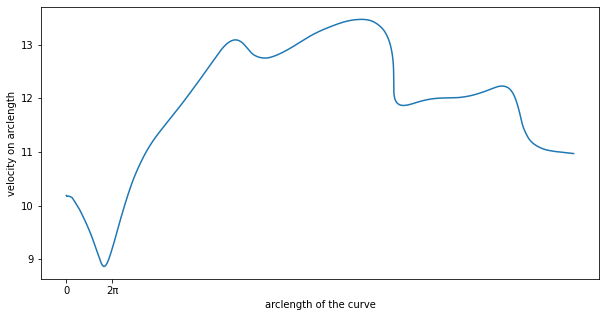

In [11]:
plot_arclength_velocities(velocities, arclength[0:velocities.size])

The figure shows the vector fields values at each time step.

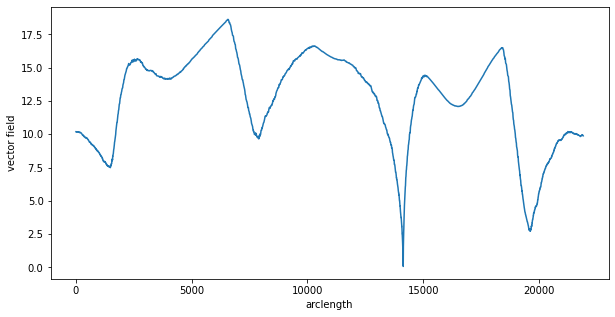

In [12]:
plot_vector_field(vector_field, arclength)

In [21]:
EPSILON = 150
L = 1000
GRID_b = np.linspace(arclength[0], arclength[-1], L)
R_COND = 1e-16

In [22]:
coefficients = utils.radial_basis_lst_sqr_approx(arclength, vector_field, GRID_b, EPSILON, R_COND)

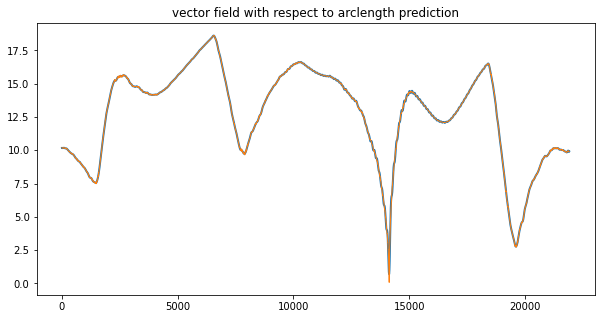

In [23]:
phi_plot = utils.radial_basis(arclength, GRID_b, epsilon=EPSILON)


plt.title("vector field with respect to arclength prediction")
plt.plot(arclength, phi_plot @ coefficients.T, linewidth=2, label="predicted non-linear function")
plt.plot(arclength, vector_field, linewidth=1, label="vector field")


### Part 4: Predict the utilization of the MI building

In [ ]:
phi_plot = utils.radial_basis(arclength, GRID_b, epsilon=EPSILON)


plt.title("vector field with respect to arclength prediction")
plt.plot(arclength, phi_plot @ coefficients.T, linewidth=2, label="predicted non-linear function")
plt.plot(arclength, vector_field, linewidth=1, label="vector field")


[1.001e+03 0.000e+00 2.000e+00 9.700e+01 7.000e+00 0.000e+00 0.000e+00
 5.000e+00 1.000e+00 4.300e+01]
(14001, 10)


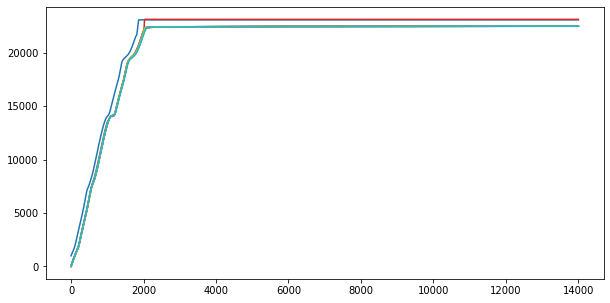

In [35]:
from scipy.integrate import solve_ivp

def fun(t, y):
    #y = y.reshape((1, y.size))
    return radial_basis(y, GRID_b, EPSILON) @ coefficients

time = U[:,0]
y0 = np.array(U[0,:])
print(y0)
sol = solve_ivp(fun, t_span=np.array([time[0], time[-1]]), y0=y0, t_eval=time).y.T
print(sol.shape)
plt.plot(sol)